In [54]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(f'{berlin_now:%Y-%m-%d %H:%M}')

2022-07-06 23:48


In [55]:
import json
import glob
import os

import urllib.parse
import urllib.request

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import SeqIO

In [56]:
structural_annotation = pd.read_parquet('/g/arendt/npapadop/repos/spongfold/data/structure_annotation.parquet')
sequence_annotation = pd.read_csv('/g/arendt/npapadop/repos/spongfold/data/Slacustris_eggnog.tsv', sep='\t')

## Comparison of Parameters for structural- sequence based annotation of proteins

In this notebook we explore how 4 different categories of annotation of the sponge proteome differ from each other in terms of parameters such as plddt, physico-chemical parameters, etc.

For that, we will first create a new table that includes structural annotations as well as the emapper based sequence annotations.

All of the ~18000 proteins in the sequence annotation table have *some* kind of annotation, even if it is just being sorted into specific OGs.

In [57]:
annotations_complete = structural_annotation[['protein_id', 'eggNOG_OGs', 'MSA size','alignment length', 'query length', 'seq. id.', 'bit score','plddt', 'complete_protein', "Preferred_name", "Description"]].merge(sequence_annotation[['protein_id', 'eggNOG_OGs', 'score', "Preferred_name", "Description"]], 
                                                                           on='protein_id', suffixes=['_struct', '_seq'], how = 'outer')

Use the same bit score cutoff for the MorF annotation:

In [58]:
bitscore_cut_off = np.exp(5)

In [59]:
seq_isnan = annotations_complete["Preferred_name_seq"].isnull()
seq_missing = annotations_complete["Preferred_name_seq"] == "-"
seq_no_desc = annotations_complete["Description_seq"].isnull()
seq_desc_mis = annotations_complete["Description_seq"] == "-"

struct_isnan = annotations_complete["Preferred_name_struct"].isnull()
struct_missing = annotations_complete["Preferred_name_struct"] == "-"
struct_no_desc = annotations_complete["Description_struct"].isnull()
struct_desc_mis = annotations_complete["Description_struct"] == "-"

seq_has_name = ~(seq_isnan | seq_missing)
seq_has_desc = ~(seq_no_desc | seq_desc_mis)
struct_has_name = ~(struct_isnan | struct_missing)
struct_has_desc = ~(struct_no_desc | struct_desc_mis)

Now we create a new column which puts a protein in one of 4 categories:

    - str_seq: Structure (above bitscore cutoff) as well as sequence annotation (either name or description) available
    - str_noseq: Structure (above bitscore cutoff) (either name or description) but no sequence annotation available
    - nostr_seq: No structure (or structure below bitscore cutoff) but sequence annotation (either name or description) available
    - nostr_noseq: No structure (or structure below bitscore cutoff) and no sequence annotation available
    

In [60]:
conditions = [
    ((seq_has_name | seq_has_desc) & (struct_has_name | struct_has_desc) & (annotations_complete['bit score'] >= bitscore_cut_off)),
    ((seq_has_name | seq_has_desc) & (struct_has_name | struct_has_desc) & (annotations_complete['bit score'] < bitscore_cut_off)),
    (~(seq_has_name | seq_has_desc) & (struct_has_name | struct_has_desc) & (annotations_complete['bit score'] >= bitscore_cut_off)),
    (~(seq_has_name | seq_has_desc) & (struct_has_name | struct_has_desc) & (annotations_complete['bit score'] < bitscore_cut_off)),
    ((seq_has_name | seq_has_desc) & ~(struct_has_name | struct_has_desc)),
    (~(seq_has_name | seq_has_desc) & ~(struct_has_name | struct_has_desc))
    ]

values = ['str_seq', 'nostr_seq', 'str_noseq', 'nostr_noseq', 'nostr_seq', 'nostr_noseq']

In [61]:
annotations_complete['annotation_category'] = np.select(conditions, values)

No handles with labels found to put in legend.


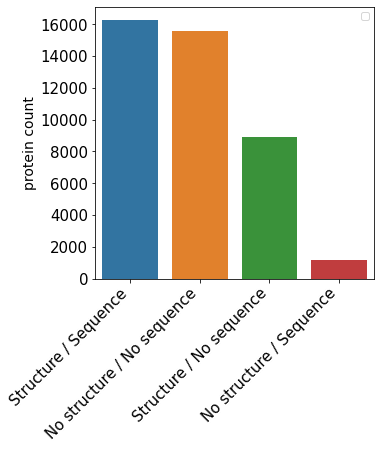

In [121]:
cats = ['Structure / Sequence', 'No structure / No sequence', 'Structure / No sequence', 'No structure / Sequence']

fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='annotation_category', data=annotations_complete, ax=ax, order = annotations_complete['annotation_category'].value_counts().index)
ax.set_xticklabels(cats, rotation = 45, ha = 'right')
ax.tick_params(labelsize = 15)
plt.ylabel('protein count', fontsize=14)
ax.set(xlabel=None)
fig = fig.get_figure()
fig.savefig('./figures/analysis-annotation_cat-barplot.svg')

First we want to compare parameters from AlphaFold (plddt, MSA size) and Foldseek (bit score) in different annotation categories

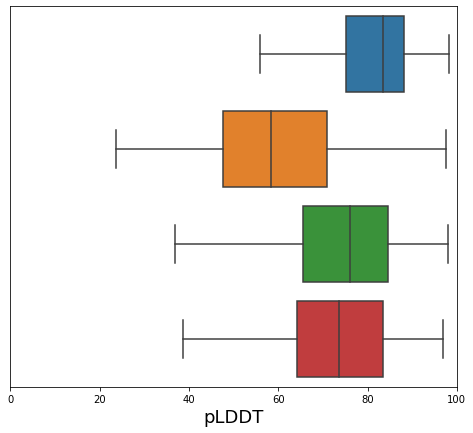

In [125]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='plddt', ax=ax, fliersize=0, order = annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(0, 100);
plt.xlabel('pLDDT', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-plddt.svg')

As expected, plddt is higher in cases where structural annotation is available. However in cases where only sequence annotation is availabe, plddt is similarly high.

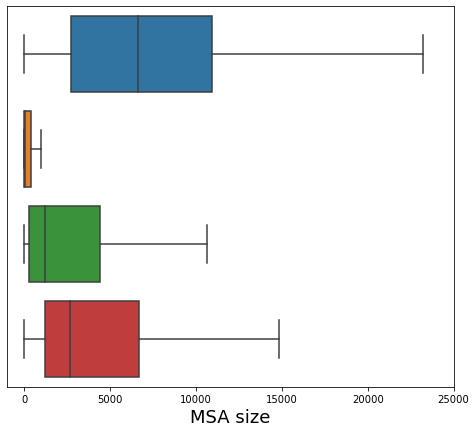

In [102]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='MSA size', ax=ax, fliersize=0, order = annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(-1000, 25000)
plt.xlabel('MSA size', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-msa.svg')

In cases where sequence annotation is found, the MSA sizes are relatively bigger.

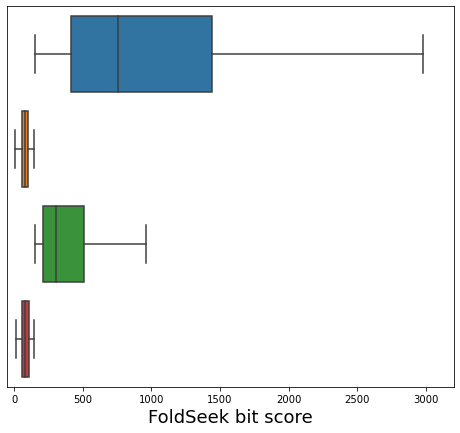

In [104]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='bit score', ax=ax, fliersize=0, order=annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(-50, 3200)
plt.xlabel('FoldSeek bit score', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-bitscore.svg')

In [105]:
annotations_complete['rel. aln length (FS)'] = annotations_complete['alignment length']/annotations_complete['query length']
annotations_complete["corrected bit score"] = annotations_complete['bit score']/annotations_complete['rel. aln length (FS)']

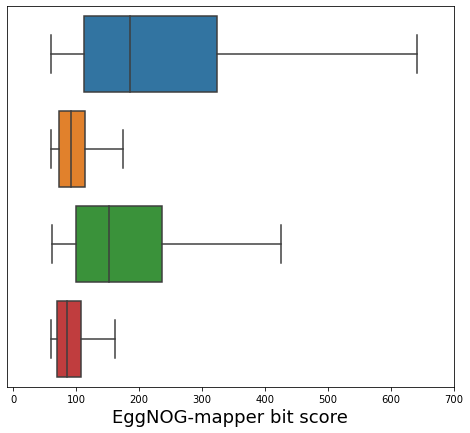

In [107]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='score', ax=ax, fliersize=0, order = annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(-10, 700)
plt.xlabel('EggNOG-mapper bit score', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-eggnog_score.svg')

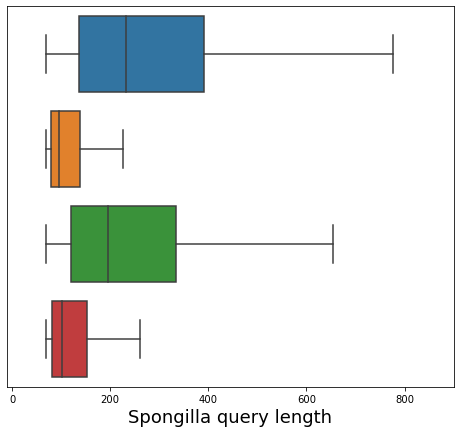

In [13]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='query length', ax=ax, fliersize=0, order = annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(-10, 900)
plt.xlabel('Spongilla query length', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-query_length.svg')

We want to test now if there is anything specific about the physico-chemical properties of these categories. For this I first have to parse the original fasta file of the spongilla sequences.

In [17]:
records = list(SeqIO.parse("/g/arendt/Fabian/PhD/Computational/Spongefold/spongilla_lacustris_Trinity.fasta.transdecoder_70AA_mediumheader.pep", "fasta"))

In [18]:
handle_list =[]
fasta_list = []


for i in range(len(records)):
    handle_list.append(records[i].id)
    fasta_list.append(str(records[i].seq).replace('*', ''))

d = {'protein_id':handle_list,'fasta':fasta_list}
df_fasta = pd.DataFrame(d)
    

ProtParam from BioPython allows to calculate a few different physico-chemical parameters:

In [19]:
N = len(df_fasta)
isoelectric_points = [''] * N
molecular_weight = [''] * N
aromaticity = [''] * N
instability_index = [''] * N
flexibility = [''] * N
gravy = [''] * N

for i, protein in enumerate(tqdm(df_fasta['fasta'].values)):
    res = ProteinAnalysis(protein, monoisotopic=False)
    isoelectric_points[i] = res.isoelectric_point()
    molecular_weight[i] = res.molecular_weight()
    aromaticity[i] = res.aromaticity()
    instability_index[i] = res.instability_index()
    flexibility[i] = res.flexibility()
    gravy[i] = res.gravy()

100%|██████████| 41945/41945 [00:41<00:00, 1020.44it/s]


In [29]:
df_fasta['isoelectric_points'] = isoelectric_points
df_fasta['molecular_weight'] = molecular_weight
df_fasta['aromaticity'] = aromaticity
df_fasta['instability_index'] = instability_index
df_fasta['flexibility'] = flexibility
df_fasta['gravy'] = gravy

Extract the actual protein ID from the first column to help us match other tables:

In [30]:
df_fasta['protein_id'] = df_fasta['protein_id'].str.split('.').str[1].astype(str).astype(int)

In [31]:
df_fasta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41945 entries, 0 to 41944
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   protein_id          41945 non-null  int64  
 1   fasta               41945 non-null  object 
 2   isoelectric_points  41945 non-null  float64
 3   molecular_weight    41945 non-null  float64
 4   aromaticity         41945 non-null  float64
 5   instability_index   41945 non-null  float64
 6   flexibility         41945 non-null  object 
 7   gravy               41945 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.6+ MB


In [32]:
annotations_complete = annotations_complete.merge(df_fasta, on='protein_id', how = 'outer')

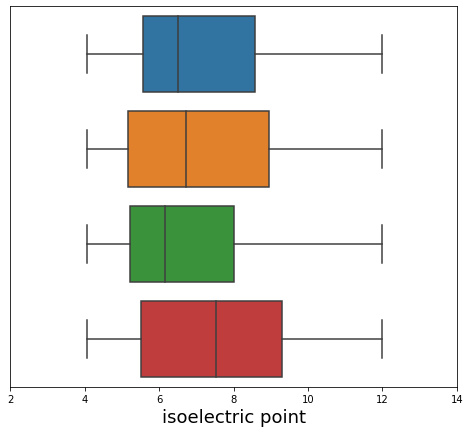

In [33]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='isoelectric_points', ax=ax, fliersize=0, order = annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(2, 14);
plt.xlabel('isoelectric point', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-isoelectric_point.svg')

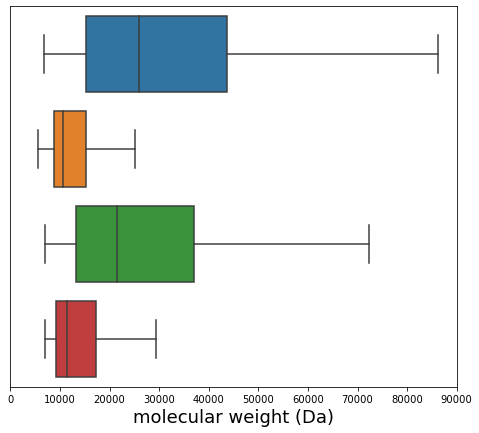

In [34]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='molecular_weight', ax=ax, fliersize=0, order=annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(0, 90000);
plt.xlabel('molecular weight (Da)', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-molecular_weight.svg')

This shows that bigger proteins have a higher tendency to have a MorF annotation.

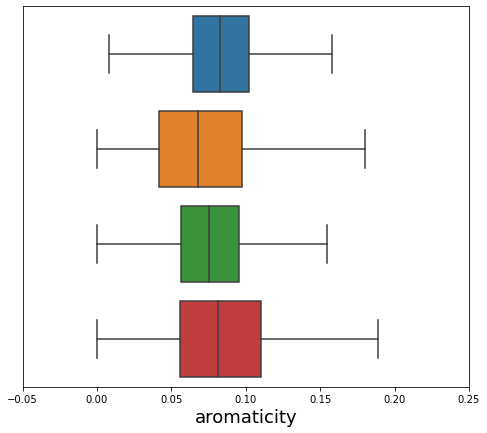

In [35]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='aromaticity', ax=ax, fliersize=0, order=annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(-0.05, 0.25);
plt.xlabel('aromaticity', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-aromaticity.svg')

In [36]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='instability_index', ax=ax, fliersize=0, order=annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(0, 100);
plt.xlabel('instability index', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-instability_index.svg')

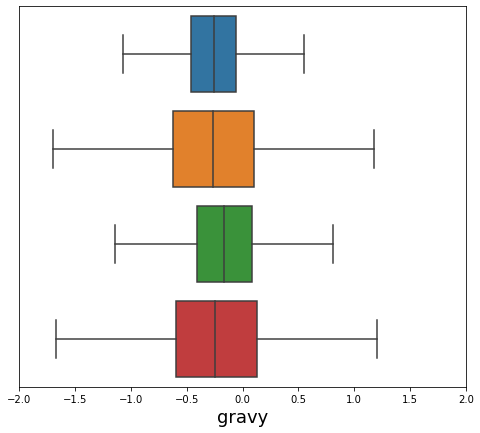

In [37]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='gravy', ax=ax, fliersize=0, order=annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(-2, 2);
plt.xlabel('gravy', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-gravy.svg')

In [38]:
annotations_complete['flexibility_average'] = annotations_complete['flexibility'].apply(np.mean)

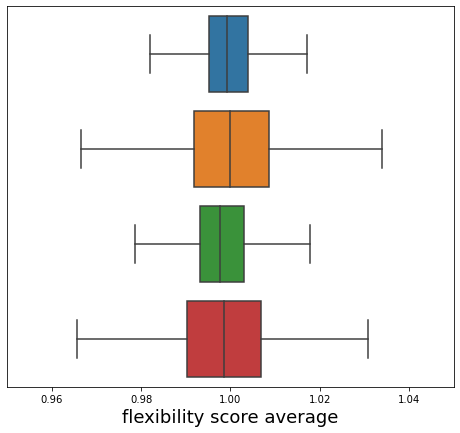

In [39]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.boxplot(data=annotations_complete, y='annotation_category', x='flexibility_average', ax=ax, fliersize=0, order=annotations_complete['annotation_category'].value_counts().index)
ax.set_xlim(0.95, 1.05);
plt.xlabel('flexibility score average', fontsize=18)
ax.set(ylabel=None);
plt.tick_params(left = False, labelleft = False)
plt.savefig('./figures/analysis-annotation_cat-flexibility.svg')

Although average flexibility scores across annotation categories seem to be similary, it is apparent that the bandwidth of flexibility is much more narrow in the proteins which have a structural annotation. Flexible proteins have a harder time to be correctly predicted.

Next, we wanted to check for correlation between AlphaFold/FoldSeek parameters and the physico-chemical properties of the amino acid sequences:

In [ ]:
annotations_complete["rel. aln length (FS)"] = annotations_complete[""]

In [41]:
correlatable = annotations_complete[['MSA size', 'query length', 'alignment length', 'seq. id.', 'bit score', 'score', 'plddt', 'isoelectric_points', 'molecular_weight', 'aromaticity', 'instability_index', 'gravy', 'flexibility_average']].copy()

In [42]:
correlatable.columns = [
    'Spongilla MSA size (AF)',
    'Spongilla query length (AF)',
    'rel. ali. length (FS)',
    'best match str. state id. (FS)',
    '(corrected) bit score (FS)',
    'bit score (EggNOG-seq)',
    'pLDDT (AF)',
    'isoelectric points',
    'molecular weight',
    'aromaticity',
    'instability index',
    'gravy',
    'flexibility average'
]

correlatable['(corrected) bit score (FS)'] = correlatable['(corrected) bit score (FS)'] / correlatable['rel. ali. length (FS)']
correlatable['rel. ali. length (FS)'] = correlatable['rel. ali. length (FS)'] / correlatable['Spongilla query length (AF)']

In [43]:
cor = correlatable.corr()
cor = pd.DataFrame(cor, columns=cor.columns, index=cor.columns)
mask = np.triu(np.ones_like(cor))

/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


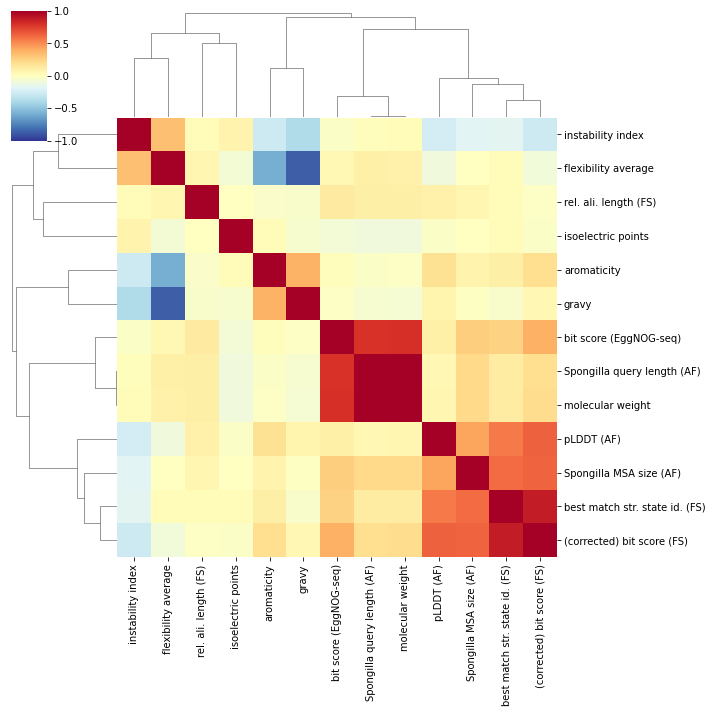

In [44]:
matrix = sns.clustermap(cor, cmap='RdYlBu_r', square=True, 
              vmin=-1, vmax=1, figsize=(10,10))

In [48]:
matrix.ax_row_dendrogram.set_visible(False)
matrix.ax_col_dendrogram.set_visible(False)
matrix.fig
matrix.savefig('./figures/analysis-annotation-sequence_structure_properties_correlation.svg')

In [68]:
novelfold = annotations_complete[(annotations_complete['annotation_category'] == "nostr_noseq") & (annotations_complete['plddt'] > 70) & (annotations_complete['bit score'].isnull())]

In [73]:
novelfold.sort_values(by = 'query length', ascending=False)[1:20]

protein_id eggNOG_OGs_struct  MSA size  alignment length  query length  \
25649       66261              None     432.0               NaN         292.0   
41478       50148              None      57.0               NaN         262.0   
15261        2847              None     100.0               NaN         261.0   
29244       27072              None      20.0               NaN         259.0   
9962        47401              None       3.0               NaN         257.0   
7372        12540              None    1313.0               NaN         243.0   
21819       85380              None    1841.0               NaN         243.0   
32410       67319              None     175.0               NaN         211.0   
22840       59630              None      72.0               NaN         210.0   
25157       25853              None     220.0               NaN         209.0   
6022        12140              None     290.0               NaN         199.0   
10699       59257              None     295.0               NaN         198.0   
6067        14136              None     347.0               NaN         196.0   
7888        41355              None       2.0               NaN         189.0   
24878       11077              None     251.0               NaN         189.0   
41137       11137              None      23.0               NaN         188.0   
16650         518              None      61.0               NaN         188.0   
11112       46005              None     383.0               NaN         184.0   
522         47403              None     408.0               NaN         177.0   

       seq. id.  bit score      plddt complete_protein Preferred_name_struct  \
25649       NaN        NaN  89.395000            False                  None   
41478       NaN        NaN  91.469237             True                  None   
15261       NaN        NaN  88.312644            False                  None   
29244       NaN        NaN  93.008378            False                  None   
9962        NaN        NaN  91.721790            False                  None   
7372        NaN        NaN  92.594321             True                  None   
21819       NaN        NaN  93.067737             True                  None   
32410       NaN        NaN  94.337062            False                  None   
22840       NaN        NaN  89.712667            False                  None   
25157       NaN        NaN  95.161196            False                  None   
6022        NaN        NaN  95.137437            False                  None   
10699       NaN        NaN  93.800657            False                  None   
6067        NaN        NaN  95.258776            False                  None   
7888        NaN        NaN  95.370000            False                  None   
24878       NaN        NaN  94.243545            False                  None   
41137       NaN        NaN  95.205745            False                  None   
16650       NaN        NaN  93.241862            False                  None   
11112       NaN        NaN  96.219239            False                  None   
522         NaN        NaN  96.385198            False                  None   

      Description_struct eggNOG_OGs_seq  score Preferred_name_seq  \
25649               None            NaN    NaN                NaN   
41478               None            NaN    NaN                NaN   
15261               None            NaN    NaN                NaN   
29244               None            NaN    NaN                NaN   
9962                None            NaN    NaN                NaN   
7372                None            NaN    NaN                NaN   
21819               None            NaN    NaN                NaN   
32410               None            NaN    NaN                NaN   
22840               None            NaN    NaN                NaN   
25157               None            NaN    NaN                NaN   
6022                None  